<a href="https://colab.research.google.com/github/darja/NeuralUni/blob/master/07_segmentation_pro_ryazhskikh.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Сегментация изображений

Есть [фреймворк моделей сегментации](https://github.com/qubvel/segmentation_models). Обучить сеть Unet или на одном из следующих датасетов:
* [Cityscapes](https://www.cityscapes-dataset.com/) 
* https://drive.google.com/file/d/0B0d9ZiqAgFkiOHR1NTJh.. 

# Подготовка окружения

In [0]:
from keras.models import Model
from keras.layers import Input, Conv2DTranspose, concatenate, Activation, MaxPooling2D, Conv2D, BatchNormalization
from keras.optimizers import Adam, SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.utils import to_categorical, plot_model
from keras import backend as K

import tensorflow.image as img

from IPython.display import Image
import matplotlib.pyplot as plt

import numpy as np
import glob
import imageio

# Утилиты
def read_image(filename):
    return imageio.imread(filename)

def display_image(filename):
    with open(filename,'rb') as f:
        display(Image(data=f.read(), format='png'))

# Подготовка входных данных

## Подготовка файловой структуры

In [0]:
!unzip dataset1.zip

In [0]:
!mkdir train_images
!mv dataset1/images_prepped_train train_images

!mkdir train_annotations
!mv dataset1/annotations_prepped_train train_annotations

!mkdir test_images
!mv dataset1/images_prepped_test test_images

!mkdir test_annotations
!mv dataset1/annotations_prepped_test test_annotations

## Входные параметры

In [0]:
K.clear_session()

# Пути к изображениям
train_image_dir = 'train_images'
train_annotation_dir = 'train_annotations'

test_image_dir = 'test_images'
test_annotation_dir = 'test_annotations'

image_files = glob.glob(train_image_dir + "/images_prepped_train/*.png") 
annotation_files = glob.glob(train_annotation_dir + "/annotations_prepped_train/*.png") 

# Размеры изображений
image_height, image_width = 360, 480
target_height, target_width = 352, 480

orig_size = (image_height, image_width)
target_size = (target_height, target_width)
target_shape = (target_height, target_width, 3)

# Типы сегментов
num_classes = 12

# Другое
batch_size = 6
steps_per_epoch = len(image_files) / batch_size
val_steps_per_epoch = len(annotation_files) / batch_size

## Просмотр изображений

train_images/images_prepped_train/0006R0_f02730.png


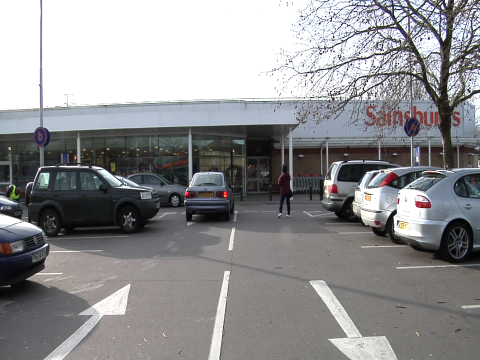

(360, 480, 3)
train_annotations/annotations_prepped_train/0006R0_f02730.png


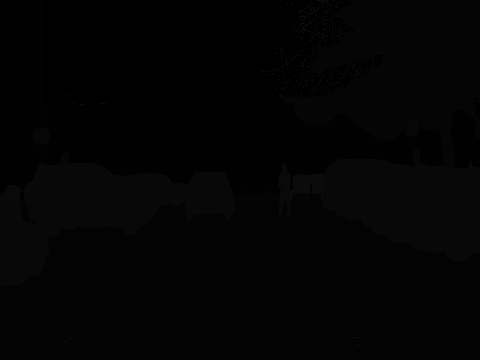

(360, 480)


In [0]:
idx = 15

# Image
filename = image_files[idx]
print(filename)
display_image(filename)

content = read_image(filename)
print(content.shape)

# Annotation
filename = annotation_files[idx]
print(filename)
with open(filename,'rb') as f:
    display(Image(data=f.read(), format='png'))

ann = read_image(filename)
print(ann.shape)

## Генератор входных изображений

In [0]:
def crop(batch_images): 
    dh = (image_height - target_height) // 2
    dw = (image_width - target_width) // 2   
    return batch_images[:, dh:(image_height - dh), dw:(image_width - dw),:]

def prepare_image(image):
    return crop(image)

def prepare_label(label):
    label = crop(label)
    label = label[:,:,:,0]
    label = to_categorical(label, num_classes = num_classes)
    return label

def create_generator(args, folder, seed):
    return ImageDataGenerator(**args).flow_from_directory(
        folder,
        target_size = orig_size,
        batch_size = batch_size,
        class_mode=None,
        seed = seed)
        
def create_combined_generator(args, image_dir, annotation_dir, seed):
    image_generator = create_generator(args, image_dir, seed)
    label_generator = create_generator(args, annotation_dir, seed)
    
    combined = zip(image_generator, label_generator)
    
    for image, label in combined:
        yield (prepare_image(image), prepare_label(label))

# Создание и тренировка нейросети

## Функции для создания нейросети

In [0]:
def dice_coef(y_true, y_pred):
    return (2. * K.sum(y_true * y_pred) + 1.) / (K.sum(y_true) + K.sum(y_pred) + 1.)

def unet_elu(num_classes = num_classes, input_shape= (352, 480, 3)):
    img_input = Input(input_shape)

    # Block 1
    x = Conv2D(64, (3, 3), padding='same', name='block1_conv1')(img_input)
    x = BatchNormalization()(x)
    x = Activation('elu')(x)

    x = Conv2D(64, (3, 3), padding='same', name='block1_conv2')(x)
    x = BatchNormalization()(x)
    block_1_out = Activation('elu')(x)

    x = MaxPooling2D()(block_1_out)

    # Block 2
    x = Conv2D(128, (3, 3), padding='same', name='block2_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('elu')(x)

    x = Conv2D(128, (3, 3), padding='same', name='block2_conv2')(x)
    x = BatchNormalization()(x)
    block_2_out = Activation('elu')(x)

    x = MaxPooling2D()(block_2_out)

    # Block 3
    x = Conv2D(256, (3, 3), padding='same', name='block3_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('elu')(x)

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('elu')(x)

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv3')(x)
    x = BatchNormalization()(x)
    block_3_out = Activation('elu')(x)

    x = MaxPooling2D()(block_3_out)

    # Block 4
    x = Conv2D(512, (3, 3), padding='same', name='block4_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('elu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('elu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv3')(x)
    x = BatchNormalization()(x)
    block_4_out = Activation('elu')(x)

    x = MaxPooling2D()(block_4_out)

    # Block 5
    x = Conv2D(512, (3, 3), padding='same', name='block5_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('elu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block5_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('elu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block5_conv3')(x)
    x = BatchNormalization()(x)
    x = Activation('elu')(x)


    # Load pretrained weights.
    for_pretrained_weight = MaxPooling2D()(x)
    vgg16 = Model(img_input, for_pretrained_weight)
    vgg16.load_weights('vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5', by_name=True)

    # UP 1
    x = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('elu')(x)

    x = concatenate([x, block_4_out])
    x = Conv2D(512, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('elu')(x)

    x = Conv2D(512, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('elu')(x)

    # UP 2
    x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('elu')(x)

    x = concatenate([x, block_3_out])
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('elu')(x)

    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('elu')(x)

    # UP 3
    x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('elu')(x)

    x = concatenate([x, block_2_out])
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('elu')(x)

    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('elu')(x)

    # UP 4
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('elu')(x)

    x = concatenate([x, block_1_out])
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('elu')(x)

    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('elu')(x)

    x = Conv2D(num_classes, (3, 3), activation='softmax', padding='same')(x)

    return Model(img_input, x)

def unet(num_classes = num_classes, input_shape= (352, 480, 3)):
    img_input = Input(input_shape)

    # Block 1
    x = Conv2D(64, (3, 3), padding='same', name='block1_conv1')(img_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (3, 3), padding='same', name='block1_conv2')(x)
    x = BatchNormalization()(x)
    block_1_out = Activation('relu')(x)

    x = MaxPooling2D()(block_1_out)

    # Block 2
    x = Conv2D(128, (3, 3), padding='same', name='block2_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(128, (3, 3), padding='same', name='block2_conv2')(x)
    x = BatchNormalization()(x)
    block_2_out = Activation('relu')(x)

    x = MaxPooling2D()(block_2_out)

    # Block 3
    x = Conv2D(256, (3, 3), padding='same', name='block3_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv3')(x)
    x = BatchNormalization()(x)
    block_3_out = Activation('relu')(x)

    x = MaxPooling2D()(block_3_out)

    # Block 4
    x = Conv2D(512, (3, 3), padding='same', name='block4_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv3')(x)
    x = BatchNormalization()(x)
    block_4_out = Activation('relu')(x)

    x = MaxPooling2D()(block_4_out)

    # Block 5
    x = Conv2D(512, (3, 3), padding='same', name='block5_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block5_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block5_conv3')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)


    # Load pretrained weights.
    for_pretrained_weight = MaxPooling2D()(x)
    vgg16 = Model(img_input, for_pretrained_weight)
    vgg16.load_weights('vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5', by_name=True)

    # UP 1
    x = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = concatenate([x, block_4_out])
    x = Conv2D(512, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 2
    x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = concatenate([x, block_3_out])
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 3
    x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = concatenate([x, block_2_out])
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 4
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = concatenate([x, block_1_out])
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(num_classes, (3, 3), activation='softmax', padding='same')(x)

    return Model(img_input, x)


## Обучение нейросети

In [0]:
train_gen = create_combined_generator(dict(horizontal_flip=True), train_image_dir, train_annotation_dir, 100)
val_gen = create_combined_generator(dict(), test_image_dir, test_annotation_dir, 200)
loss = "categorical_crossentropy"
metrics = dice_coef

optimizer = Adam(lr=1e-4)
model = unet()
# plot_model(model, to_file="unet_custom.png")

model.compile(optimizer, loss=loss, metrics=[metrics])

history = model.fit_generator(
    train_gen,
    epochs = 25,
    steps_per_epoch = steps_per_epoch,
    verbose = 1,
    validation_data = val_gen, 
    validation_steps = val_steps_per_epoch,
)

Epoch 1/25
Found 101 images belonging to 1 classes.
Found 367 images belonging to 1 classes.
Found 101 images belonging to 1 classes.
Found 367 images belonging to 1 classes.
62/61 [==============================] - 225s 4s/step - loss: 1.3208 - dice_coef: 0.4566 - val_loss: 0.9959 - val_dice_coef: 0.6533
Epoch 2/25
62/61 [==============================] - 217s 4s/step - loss: 0.6150 - dice_coef: 0.7194 - val_loss: 0.7716 - val_dice_coef: 0.7454
Epoch 3/25
62/61 [==============================] - 217s 4s/step - loss: 0.4815 - dice_coef: 0.7797 - val_loss: 0.6390 - val_dice_coef: 0.7666
Epoch 4/25
62/61 [==============================] - 217s 4s/step - loss: 0.4221 - dice_coef: 0.8068 - val_loss: 0.4784 - val_dice_coef: 0.8049
Epoch 5/25
62/61 [==============================] - 217s 4s/step - loss: 0.3876 - dice_coef: 0.8220 - val_loss: 0.5382 - val_dice_coef: 0.8310
Epoch 6/25
62/61 [==============================] - 218s 4s/step - loss: 0.4044 - dice_coef: 0.8136 - val_loss: 0.5047 - 

In [0]:
# optimizer = Adam(lr=1e-4)
optimizer = SGD(lr=1e-4)
model.compile(optimizer, loss=loss, metrics=[metrics])

model.fit_generator(
    train_gen,
    epochs = 5,
    steps_per_epoch = steps_per_epoch,
    verbose = 1,
    validation_data = val_gen, 
    validation_steps = val_steps_per_epoch,
)

Epoch 1/5
62/61 [==============================] - 223s 4s/step - loss: 0.3082 - dice_coef: 0.9026 - val_loss: 0.2494 - val_dice_coef: 0.9008
Epoch 2/5
62/61 [==============================] - 217s 4s/step - loss: 0.1540 - dice_coef: 0.9218 - val_loss: 0.2495 - val_dice_coef: 0.9009
Epoch 3/5
62/61 [==============================] - 217s 4s/step - loss: 0.1436 - dice_coef: 0.9256 - val_loss: 0.2491 - val_dice_coef: 0.9008
Epoch 4/5
62/61 [==============================] - 217s 4s/step - loss: 0.1481 - dice_coef: 0.9240 - val_loss: 0.2484 - val_dice_coef: 0.9015
Epoch 5/5
62/61 [==============================] - 217s 4s/step - loss: 0.1451 - dice_coef: 0.9250 - val_loss: 0.2473 - val_dice_coef: 0.9013


# Демонстрация работы

## Утилиты

In [0]:
colors = [
    [255, 0, 0],
    [0, 255, 0],
    [0, 0, 0],
    [255, 165,0],
    [0, 128, 0],
    [0, 0, 128],
    [128, 128, 0],
    [0, 128, 128],
    [128, 0, 128],
    [128, 128, 128],
    [0, 255, 255],
    [210, 105, 30]
]

def predict_single_image(content):
    x = content
    x = np.expand_dims(x, axis=0)
    x = crop(x)
    
    prediction = model.predict(x)
    segmented = np.argmax(prediction, axis=-1)
    return segmented

def save_segmented_file(segmented, filename):
    shape = segmented.shape
    target_shape = (shape[1], shape[2], 3)
    print("Target shape: ", target_shape)
    segmented = np.reshape(segmented, shape[0] * shape[1] * shape[2])
    
    rgb = map(lambda x: colors[x], segmented)
    rgb = np.array(list(rgb))
    rgb = np.reshape(rgb, target_shape)
    
    imageio.imwrite(filename, rgb)
    
def extract_classes(pic):
    unique, counts = np.unique(pic, return_counts = True)
    
def plot_classes(pic, label):
    unique, counts = np.unique(pic, return_counts = True)
    plt.plot(unique, counts, label=label)
    
def predict_and_demonstrate(idx):
    predicted_filename = "%s_predicted.jpg" % idx
    annotated_filename = "%s_annotated.jpg" % idx
    
    # source
    source_image_filename = image_files[idx]
    content = read_image(source_image_filename)

    # annnotation
    source_annotation_filename = annotation_files[idx]
    ann = read_image(source_annotation_filename)
    ann_prepared = np.expand_dims(ann, axis = 0)
    save_segmented_file(ann_prepared, annotated_filename)
    
    prediction = predict_single_image(content)
    save_segmented_file (prediction, predicted_filename)
    
    print("Source")
    display_image(source_image_filename)
    
    print("Expected")
    display_image(annotated_filename)
    
    print("Actual")
    display_image(predicted_filename)
    
    # classes counts in original and predicted
    print("Classes counts")
    plot_classes(ann_prepared, "Original")
    plot_classes(prediction, "Predicted") 

    plt.legend()
    plt.show()

## Результаты работы

Target shape:  (360, 480, 3)


Target shape:  (352, 480, 3)
Source


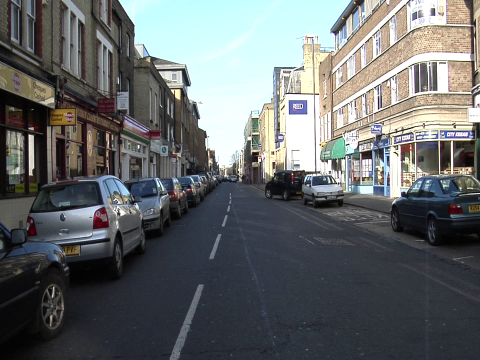

Expected


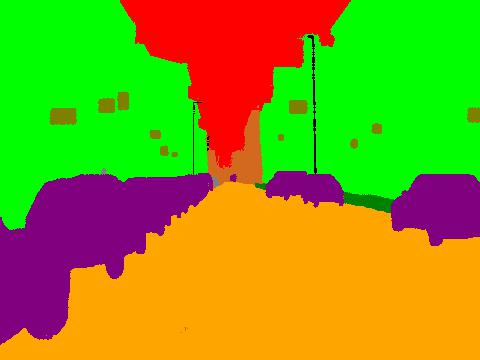

Actual


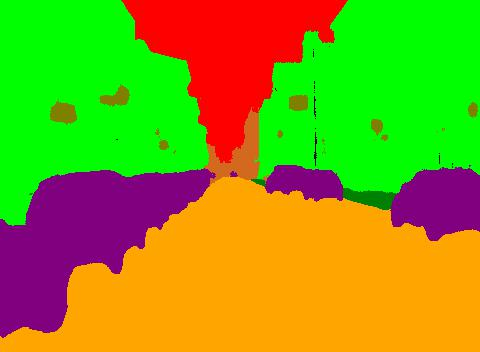

Classes counts


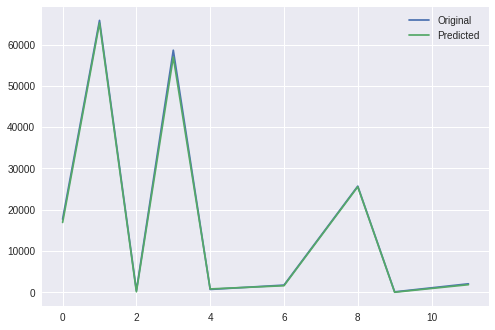

Target shape:  (360, 480, 3)


Target shape:  (352, 480, 3)
Source


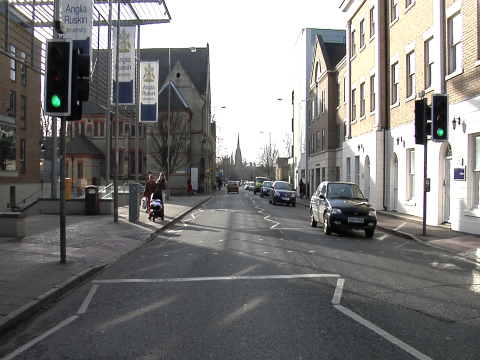

Expected


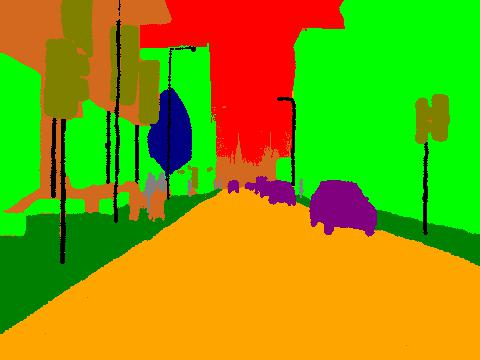

Actual


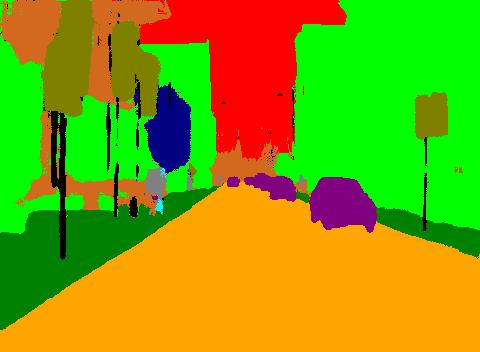

Classes counts


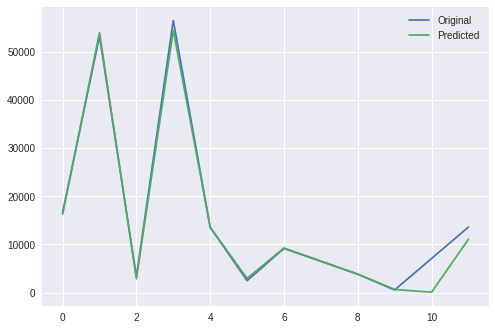

Target shape:  (360, 480, 3)


Target shape:  (352, 480, 3)
Source


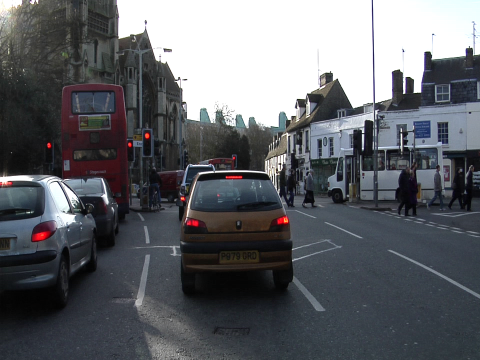

Expected


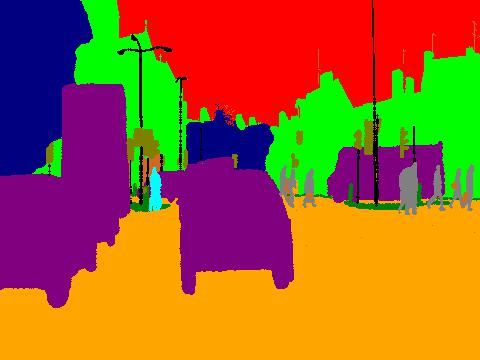

Actual


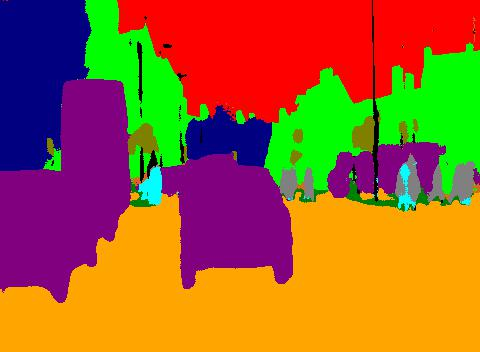

Classes counts


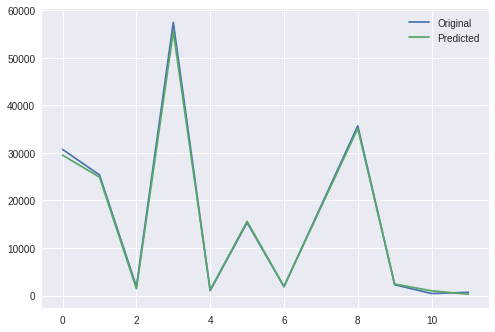

In [0]:
predict_and_demonstrate(5)
predict_and_demonstrate(98)
predict_and_demonstrate(300)

# Наблюдения

* Наилучший результат получился при batch_size = 4. Увеличение batch_size до 6 при прочих равных параметрах не привело к увеличению точности. Значения больше 6 приводят к OutOfMemory
* Если не подгружать веса VGG16, сети требуется на 5-7 эпох больше для достижения того же результата, что и с подгруженными весами.
* Замена relu на elu ухудшает результат
* В целом, результаты получаются лучше, чем при использовании Segmentation Models (90% на валидационной выборке против 81%). Кстати, в SM наилучший результат был при использовании весов resnet34, а не VGG16